In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import tensorflow as tf
import recommender
from recommender.implicit_bpr_recommender import ImplicitBPRRecommender
from recommender import FactorizationRecommender, BPRRecommender, WALSRecommender
from matrix_builder import ReportTechniqueMatrixBuilder
from tie import TechniqueInferenceEngine
import random
import math
import importlib
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

assert tf.executing_eagerly()

importlib.reload(recommender)


/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'recommender' from '/Users/mjturner/code/technique-inference-engine/models/recommender/__init__.py'>

In [2]:
validation_ratio = 0.1
test_ratio = 0.2

# data locations
dataset_filepath = "../data/combined_dataset_full_frequency.json"
enterprise_attack_filepath = "../enterprise-attack.json"

# make data
data_builder = ReportTechniqueMatrixBuilder(
    combined_dataset_filepath=dataset_filepath,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
data = data_builder.build()
# split into training and test data
train_and_validation_indices = frozenset(random.sample(data.indices, k=math.floor((1-test_ratio) * len(data.indices))))
validation_indices = frozenset(random.sample(tuple(train_and_validation_indices), k=math.floor((1-validation_ratio) * len(train_and_validation_indices))))
train_indices = frozenset(train_and_validation_indices).difference(validation_indices)
test_indices = frozenset(data.indices).difference(train_and_validation_indices)
training_data = data.mask(train_indices)
validation_data = data.mask(validation_indices)
test_data = data.mask(test_indices)

In [4]:
embedding_dimension = 10
k = 20
best_hyperparameters = {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.5, 'num_iterations': 1000, 'learning_rate': 100.0}

model = FactorizationRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.01, 0.1, 1.0, 10., 20., 50., 100.],
#     num_iterations=[1000],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
#     gravity_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [7]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization': 0.0001, 'num_iterations': 256000, 'learning_rate': 0.005}

model = BPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     num_iterations=[500 * 512],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=20)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 1.184506267600236
Precision 0.005549345257106356
Recall 0.04217497343495427
Normalized Discounted Cumulative Gain 0.045706486942448527


In [51]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization': 0.0001, 'num_iterations': 256000, 'learning_rate': 0.005}

model = ImplicitBPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     num_iterations=[math.floor(500 * 512 / training_data.to_numpy().sum())],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

  0%|          | 0/256000 [00:00<?, ?it/s]

In [8]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization_coefficient': 0.05, 'c': 0.5, 'num_iterations': 20}

model = WALSRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     num_iterations=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

/opt/homebrew/anaconda3/envs/tie2/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 20/20 [00:00<00:00, 50.81it/s]


Mean Squared Error 0.9886548077548966
Precision 0.03980357713190674
Recall 0.3784278154674671
Normalized Discounted Cumulative Gain 0.08805731433719892


In [9]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}
new_report_predictions = tie.predict_for_new_report(oilrig_techniques)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

           predictions  training_data  test_data  \
T1082         1.072645            1.0        0.0   
T1105         1.052426            1.0        0.0   
T1027         0.988334            1.0        0.0   
T1071.001     0.489124            1.0        0.0   
T1204.002     0.374016            0.0        0.0   
T1566.001     0.327866            0.0        0.0   
T1016         0.198875            0.0        0.0   
T1059.001     0.183911            0.0        0.0   
T1113         0.176998            0.0        0.0   
T1547.001     0.160393            0.0        0.0   

                                   technique_name  
T1082                System Information Discovery  
T1105                       Ingress Tool Transfer  
T1027             Obfuscated Files or Information  
T1071.001                           Web Protocols  
T1204.002                          Malicious File  
T1566.001                Spearphishing Attachment  
T1016      System Network Configuration Discovery  
T1059.001  

In [12]:
# COLD START PREDICTOR
# use one of the below sets of techniques or use your own!

# training_techniques = set(['T1021.004', 'T1572', 'T1083', 'T1570', 'T1571', 'T1105', 'T1003.001',
#     'T1005', 'T1056.001', 'T1140', 'T1555.003', 'T1569.002', 'T1113',
#     'T1018', 'T1112'
# ])
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"}
oilrig_adversary_emulation_plan_techniques = {"T1082", "T1033", "T1016", "T1087.002", "T1069.002", "T1021", "T1087.001", "T1069.001", "T1049", "T1057", "T1007", "T1012", "T1018", "T1555.004", "T1041", "T1105", "T1505.003", "T1003.001", "T1070.004", "T1572", "T1021.001", "T1569.002", "T1083", "T1048.003"}
# solarigate_techniques = set(["T1087", "T1087.002", "T1098.001", "T1098.002", "T1098.003", "T1098.005",
#     "T1583.001", "T1071.001", "T1560.001", "T1059.001", "T1059.003", "T1059.005",
#     "T1584.001", "T1555", "T1555.003", "T1213", "T1213.003", "T1005", "T1074.002",
#     "T1140", "T1587.001", "T1484.002", "T1482", "T1568", "T1114.002", "T1546.003",
#     "T1048.002", "T1190", "T1133", "T1083", "T1606.001", "T1606.002", "T1589.001",
#     "T1562.001", "T1562.002", "T1562.004", "T1070", "T1070.004", "T1070.006", "T1070.008",
#     "T1105", "T1036", "T1036.004", "T1036.005", "T1003.006", "T1069", "T1069.002",
#     "T1057", "T1090.001", "T1021.001", "T1021.002", "T1021.006", "T1018", "T1053.005",
#     "T1558.003", "T1539", "T1559.002", "T1195.002", "T1218.011", "T1082", "T1016.001",
#     "T1199", "T1552.004", "T1550", "T1550.001", "T1550.004", "T1078",
#     "T1078.002", "T1078.003", "T1078.004", "T1047",
# ])

factorization_kwargs = {
    "learning_rate": 0.5,
    "num_iterations": 10,
    "regularization_coefficient": 0.1,
    "gravity_coefficient": 1,
}

bpr_kwargs = {
    "learning_rate": 0.01,
    "num_iterations": 1000,
    "w_regularization": 0.001,
}

new_report_predictions = tie.predict_for_new_report(oilrig_techniques)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

           predictions  training_data  test_data  \
T1082         1.072645            1.0        0.0   
T1105         1.052426            1.0        0.0   
T1027         0.988334            1.0        0.0   
T1071.001     0.489124            1.0        0.0   
T1204.002     0.374016            0.0        0.0   
T1566.001     0.327866            0.0        0.0   
T1016         0.198875            0.0        0.0   
T1059.001     0.183911            0.0        0.0   
T1113         0.176998            0.0        0.0   
T1547.001     0.160393            0.0        0.0   

                                   technique_name  
T1082                System Information Discovery  
T1105                       Ingress Tool Transfer  
T1027             Obfuscated Files or Information  
T1071.001                           Web Protocols  
T1204.002                          Malicious File  
T1566.001                Spearphishing Attachment  
T1016      System Network Configuration Discovery  
T1059.001  

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 6265 samples in 0.002s...
[t-SNE] Computed neighbors for 6265 samples in 0.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6265
[t-SNE] Computed conditional probabilities for sample 2000 / 6265
[t-SNE] Computed conditional probabilities for sample 3000 / 6265
[t-SNE] Computed conditional probabilities for sample 4000 / 6265
[t-SNE] Computed conditional probabilities for sample 5000 / 6265
[t-SNE] Computed conditional probabilities for sample 6000 / 6265
[t-SNE] Computed conditional probabilities for sample 6265 / 6265
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.280106
[t-SNE] KL divergence after 8850 iterations: 0.410354


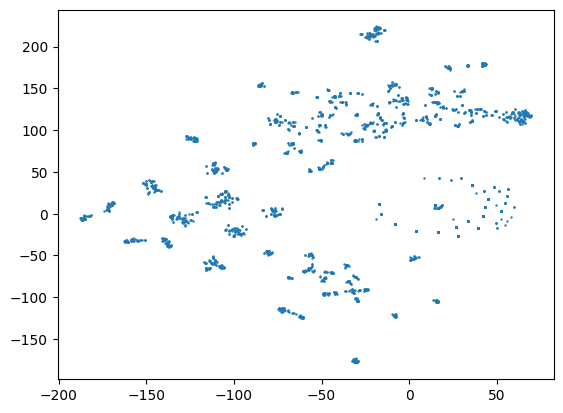

In [14]:
def make_tsne_embeddings(embeddings: np.ndarray) -> tuple[np.array, np.array]:
    """Create 2D representation of embeddings using t-SNE.

    Args:
        embeddings: an mxk array of m embeddings in k-dimensional space.

    Returns:
        A tuple of the form (x_1, x_2) where x_1 and x_2 are length m
        such that (x_1[i], x_2[i]) is the 2-dimensional point cotnaining the 2-dimensional
        repsresentation for embeddings[i, :].
    """
    tsne = sklearn.manifold.TSNE(
        n_components=2,
        perplexity=15,
        learning_rate="auto",
        # metric='cosine',
        # early_exaggeration=10.0,
        init='pca',
        verbose=True,
        n_iter=10000,
    )

    V_proj = tsne.fit_transform(embeddings)
    x = V_proj[:, 0]
    y = V_proj[:, 1]

    return x, y

U = tie.get_U()
x_1, x_2 = make_tsne_embeddings(U)

plt.scatter(x_1, x_2, s=0.5)
plt.show()